In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

dir_path = []
for dirname, _, filenames in os.walk('./archive/bbc-fulltext (document classification)/bbc/'):
    dir_path.append(dirname)

dir_path

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

['./archive/bbc-fulltext (document classification)/bbc/',
 './archive/bbc-fulltext (document classification)/bbc/entertainment',
 './archive/bbc-fulltext (document classification)/bbc/business',
 './archive/bbc-fulltext (document classification)/bbc/sport',
 './archive/bbc-fulltext (document classification)/bbc/politics',
 './archive/bbc-fulltext (document classification)/bbc/tech']

In [2]:
# !pip install --upgrade pip
# !pip install scikit-learn

# Text files to CSV

Data has 5 subfolders which are actually the labels of the news. They are politics, sports, tech, entertainment and business news. Each of these subfolders contains several news in the form of .txt files.

For easy use, I define following function to read all of these files along with their category and convert them to a single pandas CSV data frame.

In [3]:
import glob
import io
import warnings
warnings.filterwarnings("ignore")

def text_to_pandasDF(path):
    df = pd.DataFrame(columns=['news', 'class'])
    txt = []
    label = []
    
    for dirpath in path:
        text_files_path = sorted(glob.glob(os.path.join(dirpath, '*.txt')))
        
        for text_path in text_files_path:
            with io.open(text_path, 'r', encoding='utf-8', errors='ignore') as txt_file:
                txt.append(txt_file.read())
                label.append(dirpath.split('/')[-1])

    df['news'] = txt
    df['class'] = label
    txt, label = [], []
    
    return df

In [4]:
df = text_to_pandasDF(dir_path[1:])
df

,news,class
0,Gallery unveils interactive tree\n\nA Christma...,entertainment
1,Jarre joins fairytale celebration\n\nFrench mu...,entertainment
2,Musical treatment for Capra film\n\nThe classi...,entertainment
3,Richard and Judy choose top books\n\nThe 10 au...,entertainment
4,Poppins musical gets flying start\n\nThe stage...,entertainment
...,...,...
2220,BT program to beat dialler scams\n\nBT is intr...,tech
2221,Spam e-mails tempt net shoppers\n\nComputer us...,tech
2222,Be careful how you code\n\nA new European dire...,tech
2223,US cyber security chief resigns\n\nThe man mak...,tech


Let's plot histogram of each class to check whether the data is unbalanced or not:

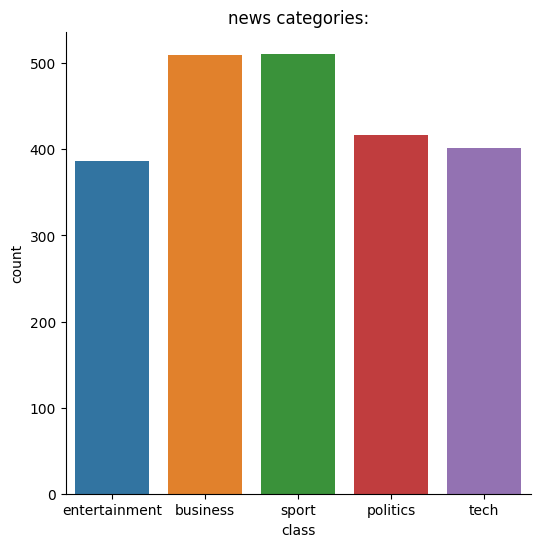

In [5]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,6))
plt.title("news categories:")
sns.countplot(x=df["class"])
sns.despine(top=True, right=True, left=False, bottom=False)

As you can see, the data is balanced; let's continue

# Data Preprocessing

As for the data has 5 classes, we should use one-hot encoding to transform label of classes. After that, we can split data to train and test sets.

In [6]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

X = df['news']

#label one_hot encoding
y = np.array(df['class'])
y = np.reshape(y, (-1,1))
y = OneHotEncoder().fit_transform(y).toarray()


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Training

in this notebook we are goin to use BERT;

BERT (Bidirectional Encoder Representations from Transformers) provides dense vector representations for natural language by using a deep, pre-trained neural network with the Transformer architecture. For more information and how to use it, check this documentation:

[https://tfhub.dev/google/collections/bert/1](http://)

BERT uses its own preprocessing, which requires tensorflow_text to be installed. So let's intall it:

In [7]:
# !pip install tensorflow_text

In [8]:
import tensorflow_hub as hub
import tensorflow_text as text

In [9]:
model_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
model_preprocessing_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

preprocessor = hub.KerasLayer(model_preprocessing_url)
encoder = hub.KerasLayer(model_url)

Metal device set to: Apple M1


2023-03-11 01:51:28.291441: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-11 01:51:28.291561: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-03-11 01:51:30.743781: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-11 01:51:30.760203: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model

#BERT Layers
input_layer = Input(shape=(), dtype=tf.string)
preprocess_layer = preprocessor(input_layer)
bert_output = encoder(preprocess_layer)

#Fully connected layers
z = Dropout(0.1)(bert_output['pooled_output'])
z = Dense(5, activation='softmax')(z)

model = Model(inputs=input_layer, outputs=z)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['input_1[0][0]']                
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [11]:
# # Include the epoch in the file name (uses `str.format`)
# checkpoint_path = "training_1/cp-{epoch:04d}.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)

# batch_size = 32

# # Create a callback that saves the model's weights every 5 epochs
# cp_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_path, 
#     verbose=1, 
#     save_weights_only=True,
#     save_freq=5*batch_size)

# # # Create a new model instance
# # model = create_model()

# # Save the weights using the `checkpoint_path` format
# model.save_weights(checkpoint_path.format(epoch=0))

# # Train the model with the new callback
# # model_history = model.fit(train_images, 
# #           train_labels,
# #           epochs=50, 
# #           batch_size=batch_size, 
# #           callbacks=[cp_callback],
# #           validation_data=(test_images, test_labels),
# #           verbose=0)
# model_history = model.fit(x=X_train,
#                           y=y_train,
#                           batch_size=32,
#                           validation_split=0.2, 
#                           callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4)],
#                           epochs=10)

In [ ]:
model_history = model.fit(x=X_train,
                          y=y_train,
                          batch_size=32,
                          validation_split=0.2, 
                          callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4)],
                          epochs=5)

Epoch 1/5


2023-03-11 01:51:51.864853: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

ax[0].plot(model_history.history['accuracy'])
ax[0].plot(model_history.history['val_accuracy'])
ax[0].set_title('model accuracy')
ax[0].set_ylabel('val_accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'val'], loc='upper left')

ax[1].plot(model_history.history['loss'])
ax[1].plot(model_history.history['val_loss'])
ax[1].set_title('model loss')
ax[1].set_ylabel('val_loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'val'], loc='upper right')

fig.show()

# Model Testing

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

plt.figure(figsize=(10,10))
ax = sns.heatmap(matrix, annot=True, fmt="d", cmap = 'rocket_r', xticklabels = ['politics', 'sports', 'tech', 'entertaintment', 'business'], yticklabels = ['politics', 'sports', 'tech', 'entertaintment', 'business'])